# Fine-tuning a Pretrained Network for Style Recognition

这个讲了从 caffe 的 model zoo 拿到别人训练好了的 model，如何把它 tune 得更适合自己的情况。

In this example, we'll explore a common approach that is particularly useful in real-world applications: take a pre-trained Caffe network and fine-tune the parameters on your custom data.

The upside of such approach is that, since pre-trained networks are learned on a large set of images, the intermediate layers capture the "semantics" of the general visual appearance. Think of it as a very powerful feature that you can treat as a black box. On top of that, only a few layers will be needed to obtain a very good performance of the data.

First, we will need to prepare the data. This involves the following parts:
(1) Get the ImageNet ilsvrc pretrained model with the provided shell scripts.
(2) Download a subset of the overall Flickr style dataset for this demo.
(3) Compile the downloaded Flickr dataset into a database that Caffe can then consume.

In [1]:
import os
os.chdir('..')
print os.path.realpath(os.getcwd())

import sys
sys.path.insert(0, './python')

import caffe
import numpy as np
from pylab import *
%matplotlib inline

/home/tzx/dev/caffe-rc3


In [8]:
# This downloads the ilsvrc auxiliary data (mean file, etc),
# and a subset of 2000 images for the style recognition task.

#!data/ilsvrc12/get_ilsvrc_aux.sh
# 还是用我们已经下载好了的数据。cp 过来就好。
!data/ilsvrc12/get_ilsvrc_aux_cvrs.sh 
print "done get files.\n"

# 提前解压这个文件，用【迅雷】把图片下载了直接拷贝过去。
# examples/finetune_flickr_style/flickr_style.csv.gz

# 如果图片已经存在，这个脚本不会再下载（还得通过sha1 校验）。
!scripts/download_model_binary.py models/bvlc_reference_caffenet
print "done get model binary.\n"

!python examples/finetune_flickr_style/assemble_data.py \
    --workers=-1 --images=2000 --seed=1701 --label=5
print "done assemble.\n"

Copying from /home/tzx/datasets/datasets...
Unzipping...
total 79M
drwxrwxr-x 2 tzx tzx 4.0K  6月 21 15:37 .
drwxrwxr-x 6 tzx tzx 4.0K  6月 15 18:04 ..
-rw-r--r-- 1 tzx tzx  18M  6月 21 15:37 caffe_ilsvrc12.tar.gz
-rw-r--r-- 1 tzx tzx 3.7K  6月  9  2014 det_synset_words.txt
-rwxrwxr-x 1 tzx tzx  593  6月 21 15:21 get_ilsvrc_aux_cvrs.sh
-rwxrwxr-x 1 tzx tzx  585  1月 30 11:02 get_ilsvrc_aux.sh
-rw-r--r-- 1 tzx tzx  15M  7月 12  2014 imagenet.bet.pickle
-rw-r--r-- 1 tzx tzx  187  2月 25  2014 ._imagenet_mean.binaryproto
-rw-r--r-- 1 tzx tzx 769K  2月 25  2014 imagenet_mean.binaryproto
-rw-r--r-- 1 tzx tzx  187  2月 25  2014 ._synsets.txt
-rw-r--r-- 1 tzx tzx 9.8K  2月 25  2014 synsets.txt
-rw-r--r-- 1 tzx tzx  187  4月  9  2014 ._synset_words.txt
-rw-r--r-- 1 tzx tzx  31K  4月  9  2014 synset_words.txt
-rw-r--r-- 1 tzx tzx  187  2月 25  2014 ._test.txt
-rw-r--r-- 1 tzx tzx 3.1M  2月 25  2014 test.txt
-rw-r--r-- 1 tzx tzx  187  2月 25  2014 ._train.txt
-rw-r--r-- 1 tzx tzx  42M  2月 25  2014 train.txt
-rw

Let's show what is the difference between the fine-tuning network and the original caffe model.

In [3]:
!diff models/bvlc_reference_caffenet/train_val.prototxt models/finetune_flickr_style/train_val.prototxt

1c1
< name: "CaffeNet"
---
> name: "FlickrStyleCaffeNet"
4c4
<   type: "Data"
---
>   type: "ImageData"
15,26c15,19
< # mean pixel / channel-wise mean instead of mean image
< #  transform_param {
< #    crop_size: 227
< #    mean_value: 104
< #    mean_value: 117
< #    mean_value: 123
< #    mirror: true
< #  }
<   data_param {
<     source: "examples/imagenet/ilsvrc12_train_lmdb"
<     batch_size: 256
<     backend: LMDB
---
>   image_data_param {
>     source: "data/flickr_style/train.txt"
>     batch_size: 50
>     new_height: 256
>     new_width: 256
31c24
<   type: "Data"
---
>   type: "ImageData"
42,51c35,36
< # mean pixel / channel-wise mean instead of mean image
< #  transform_param {
< #    crop_size: 227
< #    mean_value: 104
< #    mean_value: 117
< #    mean_value: 123
< #    mirror: false
< #  }
<   data_param {
<     source: "examples/imagenet/ilsvrc12_val_lmdb"
---
>   image_data_param {
>     source: "data/flickr_style/test.txt"
53c38,39
<     backend: LMDB
---
>     

For your record, if you want to train the network in pure C++ tools, here is the command:

<code>
build/tools/caffe train \
    -solver models/finetune_flickr_style/solver.prototxt \
    -weights models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel \
    -gpu 0
</code>

However, we will train using Python in this example.

In [10]:
niter = 200
# losses will also be stored in the log
train_loss = np.zeros(niter)
scratch_train_loss = np.zeros(niter)

caffe.set_device(0)
caffe.set_mode_gpu()

# We create a solver that fine-tunes from a previously trained network.
solver = caffe.SGDSolver('models/finetune_flickr_style/solver.prototxt')
# 这里把之前的模型载入了。
solver.net.copy_from('models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')

# 对比这个 scratch_solver，
# 没有载入新的模型。For reference, we also create a solver that does no finetuning.
scratch_solver = caffe.SGDSolver('models/finetune_flickr_style/solver.prototxt')

# We run the solver for niter times, and record the training loss.
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    scratch_solver.step(1)
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    scratch_train_loss[it] = scratch_solver.net.blobs['loss'].data
    if it % 10 == 0:
        print 'iter %d, finetune_loss=%f, scratch_loss=%f' % (it, train_loss[it], scratch_train_loss[it])

iter 0, finetune_loss=3.487237, scratch_loss=3.350521
iter 10, finetune_loss=2.474704, scratch_loss=5.074236
iter 20, finetune_loss=2.328866, scratch_loss=2.397179
iter 30, finetune_loss=1.509140, scratch_loss=1.967646
iter 40, finetune_loss=1.569238, scratch_loss=2.004106
iter 50, finetune_loss=1.342260, scratch_loss=1.780126
iter 60, finetune_loss=1.528000, scratch_loss=1.821887
iter 70, finetune_loss=1.651778, scratch_loss=1.779577
iter 80, finetune_loss=1.292771, scratch_loss=1.625286
iter 90, finetune_loss=1.738845, scratch_loss=1.856904
iter 100, finetune_loss=1.101822, scratch_loss=1.778781
iter 110, finetune_loss=1.237936, scratch_loss=1.722533
iter 120, finetune_loss=1.073700, scratch_loss=1.834855
iter 130, finetune_loss=0.994269, scratch_loss=1.678407
iter 140, finetune_loss=1.075016, scratch_loss=1.671051
iter 150, finetune_loss=0.823929, scratch_loss=1.670013
iter 160, finetune_loss=0.967891, scratch_loss=1.646255
iter 170, finetune_loss=1.266417, scratch_loss=1.703622
ite

Let's look at the training loss produced by the two training procedures respectively.

train_loss 和 scratch_train_loss 都是 ndarray, 通过 `np.zeros(num)` 定义的。

<type 'numpy.ndarray'>


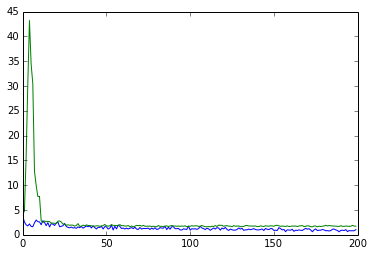

In [9]:
print type(train_loss)
plot(np.vstack([train_loss, scratch_train_loss]).T)

Notice how the fine-tuning procedure produces a more smooth loss function change, and ends up at a better loss. A closer look at small values, clipping to avoid showing too large loss during training:

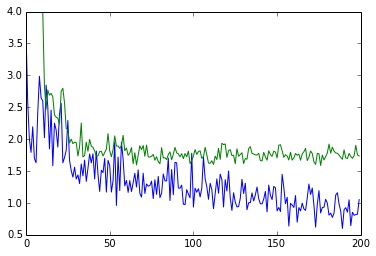

In [6]:
plot(np.vstack([train_loss, scratch_train_loss]).clip(0, 4).T)

Let's take a look at the testing accuracy after running 200 iterations. Note that we are running a classification task of 5 classes, thus a chance accuracy is 20%. As we will reasonably expect, the finetuning result will be much better than the one from training from scratch. Let's see.

In [7]:
test_iters = 10
accuracy = 0
scratch_accuracy = 0
for it in arange(test_iters):
    solver.test_nets[0].forward()
    accuracy += solver.test_nets[0].blobs['accuracy'].data
    scratch_solver.test_nets[0].forward()
    scratch_accuracy += scratch_solver.test_nets[0].blobs['accuracy'].data
accuracy /= test_iters
scratch_accuracy /= test_iters
print 'Accuracy for fine-tuning:', accuracy
print 'Accuracy for training from scratch:', scratch_accuracy

Accuracy for fine-tuning: 0.584000003338
Accuracy for training from scratch: 0.218000002205


Huzzah! So we did finetuning and it is awesome. Let's take a look at what kind of results we are able to get with a longer, more complete run of the style recognition dataset. Note: the below URL might be occassionally down because it is run on a research machine.

http://demo.vislab.berkeleyvision.org/